#### Predictive Modeling with PyTorch, Lung Cancer Dataset 

In [ ]:
!pip install -U torch torchvision torchtext torchaudio --quiet
!pip install -U pytorch-lightning --quiet
!pip install -U opendatasets --upgrade --quiet

In [ ]:
import os,json, logging, zipfile, shutil
from pathlib import Path
from collections import OrderedDict
import opendatasets as od, pandas as pd,  numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.utils import save_image
import pytorch_lightning as pl
pd.__version__, np.__version__, torch.__version__, pl.__version__

('2.2.2', '1.26.4', '2.6.0+cu124', '2.5.0.post0')

In [ ]:
from google.colab import files
files.upload()

In [ ]:
DATA_PATH = Path('data')
KAGGLE_JSON = DATA_PATH/'kaggle.json'
IS_KAGGLE_KEY = KAGGLE_JSON.exists()
KAGGLE_API = None
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip

In [ ]:
cancer_labels = pd.read_csv('train_labels.csv')

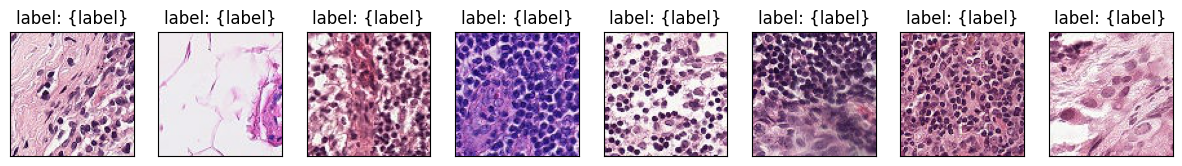

In [ ]:
np.random.seed(0)
train_imgs_lst = os.listdir('train')
selected_img_lst = []
for img in np.random.choice(train_imgs_lst, 10000):
  selected_img_lst.append(img)
fig = plt.figure(figsize=(15, 5))
for index, img in enumerate(np.random.choice(selected_img_lst, 8)):
  ax = fig.add_subplot(1, 8, index+1, xticks=[], yticks=[])
  img_n = Image.open('train/' +img)
  plt.imshow(img_n)
  label = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0],'label'].values[0]
  ax.set_title("label: {label}")

In [ ]:
image_size = 64
batch_size = 128
normalize = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
latent_size = 256

In [ ]:
!mkdir train_ds
!mkdir test_ds
!chmod 775 train_ds
!chmod 775 test_ds
#!ls -l train_ds
!ls -l test_ds

In [ ]:
np.random.seed(0)
np.random.shuffle(selected_img_lst)
cancer_train, cancer_test = selected_img_lst[:9000], selected_img_lst[9000:]
for filename in cancer_train:
  src = os.path.join('train', filename)
  dst = os.path.join('train_ds', filename)
  shutil.copyfile(src, dst)
for filename in cancer_test:
  src = os.path.join('train', filename)
  dst = os.path.join('test_ds', filename)
  shutil.copyfile(src, dst)

data_transform_train = T.Compose([
  T.CenterCrop(image_size), T.RandomHorizontalFlip(), T.RandomVerticalFlip(),
  T.Resize(image_size), T.ToTensor(),  T.Normalize(*normalize)])

data_transform_test = T.Compose([
  T.CenterCrop(image_size), T.RandomHorizontalFlip(), T.RandomVerticalFlip(),
  T.Resize(image_size), T.ToTensor(), T.Normalize(*normalize)])

def denormalize(image_tensors):
    image_tensors = image_tensors * normalize[1][0]
    image_tensors = image_tensors + normalize[0][0]
    return image_tensors

def display_images(images, total_images_to_display = 64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    images= images.detach()
    images = images[:total_images_to_display]
    denormalize_images = denormalize(images)

    ax.imshow(make_grid(denormalize_images, nrow=8).permute(1, 2, 0))

In [ ]:
id_list, label_list = [], []
selected_img_labels=pd.DataFrame()

for img in selected_img_lst:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

selected_img_labels['id'] = id_list
selected_img_labels['label'] = label_list
img_label_dict = {k:v for k, v in zip(selected_img_labels.id, selected_img_labels.label)}
selected_img_labels.head()[:2], len(selected_img_labels), #img_label_dict

(                                         id  label
 0  dafeced682481709ffd3e2004135d5b6566018d4      0
 1  d2e975d14155dc21b26e2a35da9e4800f3c4a32a      1,
 10000)

In [ ]:
from PIL import Image as PilImage
class CancerDataset(Dataset):
  def __init__(self, data_folder,
               transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
    self.data_folder = data_folder
    self.list_image_files = [s for s in os.listdir(data_folder)]
    self.transform = transform
    self.dict_labels = dict_labels
    self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

  def __len__(self):
    return len(self.list_image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.list_image_files[idx])
    image = PilImage.open(img_name)
    image = self.transform(image)
    img_name_short = self.list_image_files[idx].split('.')[0]

    label = self.dict_labels[img_name_short]
    return image, label

train_set = CancerDataset(
    data_folder='/content/train_ds/',
    transform=data_transform_train, dict_labels=img_label_dict)
test_set = CancerDataset(
    data_folder='/content/test_ds/',
    transform=data_transform_train, dict_labels=img_label_dict)

'''
train_set = ImageFolder('/content/train_ds', transform=data_transform_train)
test_set = ImageFolder('/content/test_ds', transform=data_transform_train)
'''

batch_size = 256

train_dataloader = DataLoader(
    train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(
    test_set, batch_size, num_workers=2, pin_memory=True)

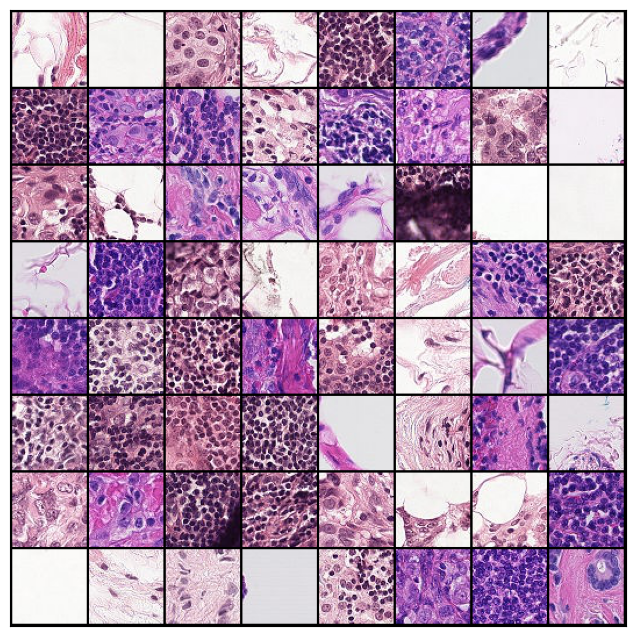

In [ ]:
for images, _ in train_dataloader:
  display_images(images)
  break

In [ ]:
def save_generated_samples(index, sample_images):
    fake_fname = 'generated-images-{}.png'.format(index)
    print(fake_fname)
    save_image(denormalize(sample_images[-64:]), os.path.join(".", fake_fname), nrow=8)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.input_size = input_size
        self.channel = 3
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False
        self.negative_slope = 0.2

        #input size: (3,64,64)
        self.conv1 = nn.Conv2d(self.channel, 128, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.LeakyReLU(self.negative_slope, inplace=True)

        #input size: (128,32,32)
        self.conv2 =  nn.Conv2d(128, 256, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn2 = nn.BatchNorm2d(256)

        #input size: (256,16,16)
        self.conv3 =  nn.Conv2d(256, 512, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn3 = nn.BatchNorm2d(512)

        #input size: (512,8,8)
        self.conv4 =  nn.Conv2d(512, 1024, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn4 = nn.BatchNorm2d(1024)

        self.fc = nn.Sequential(
            nn.Linear(in_features=16384,out_features=1), nn.Sigmoid() )

    def forward(self, input_img):
        validity = self.conv1(input_img)
        validity = self.bn1(validity)
        validity = self.relu(validity)
        validity = self.conv2(validity)
        validity = self.bn2(validity)
        validity = self.relu(validity)
        validity = self.conv3(validity)
        validity = self.bn3(validity)
        validity = self.relu(validity)
        validity = self.conv4(validity)
        validity = self.bn4(validity)
        validity = self.relu(validity)
        validity=validity.view(-1, 1024*4*4)
        validity=self.fc(validity)
        return validity


In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_size = 256):
    super().__init__()
    self.latent_size = latent_size
    self.kernel_size = 4
    self.stride = 2
    self.padding = 1
    self.bias = False

    self.model = nn.Sequential(
      #input size: (latent_size,1,1)
      nn.ConvTranspose2d(latent_size, 512, kernel_size=self.kernel_size,
                               stride=1, padding=0, bias=self.bias),
      nn.BatchNorm2d(512),
      nn.ReLU(True),
      #input size: (512,4,4)
      nn.ConvTranspose2d(512, 256, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias),
      nn.BatchNorm2d(256),
      nn.ReLU(True),
      #input size: (256,8,8)
      nn.ConvTranspose2d(256, 128, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias),
      nn.BatchNorm2d(128),
      nn.ReLU(True),
      #input size: (128,16,16)
      nn.ConvTranspose2d(128, 64, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      nn.ConvTranspose2d(64, 3, kernel_size=self.kernel_size,
                      stride=self.stride, padding=self.padding, bias=self.bias),
      nn.Tanh()
              # output size: 3 x 64 x 64
      )

    def forward(self, input_img):
        input_img = self.model(input_img)
        return input_img


In [ ]:
ALL_IMAGES = []
class GAN(pl.LightningModule):

    def __init__(self, latent_size = 256,learning_rate = 0.0002,bias1 = 0.5,
                 bias2 = 0.999,batch_size = 128):
      super().__init__()
      self.save_hyperparameters()
      # networks
      # data_shape = (channels, width, height)
      self.generator = Generator()
      self.discriminator = Discriminator(input_size=64)
      self.batch_size = batch_size
      self.latent_size = latent_size
      self.validation = torch.randn(self.batch_size, self.latent_size, 1, 1)
      self.automatic_optimization = False
      # self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
      return self.generator(z)

    def adversarial_loss(self, preds, targets):
      return F.binary_cross_entropy(preds, targets)

    def training_step(self, batch, batch_idx):
      real_images, _ = batch
      opt_g, opt_d = self.optimizers()
      print(opt_g, opt_d)
      # train generator
      if opt_g == 0:
        # Generate fake images
        fake_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
        fake_random_noise = fake_random_noise.type_as(real_images)
        fake_images = self(fake_random_noise) #self.generator(latent)
        # Try to fool the discriminator
        preds = self.discriminator(fake_images)
        targets = torch.ones(self.batch_size, 1)
        targets = targets.type_as(real_images)

        loss = self.adversarial_loss(preds, targets)
        self.log('generator_loss', loss, prog_bar=True)

        tqdm_dict = {'g_loss': loss}
        output = OrderedDict({
            'loss': loss, 'progress_bar': tqdm_dict, 'log': tqdm_dict
        })
        return output

      # train discriminator
      if opt_d == 1:
        # Pass real images through discriminator
        real_preds = self.discriminator(real_images)
        real_targets = torch.ones(real_images.size(0), 1)
        real_targets = real_targets.type_as(real_images)
        real_loss = self.adversarial_loss(real_preds, real_targets)
        # real_score = torch.mean(real_preds).item()

        # Generate fake images
        real_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
        real_random_noise = real_random_noise.type_as(real_images)
        fake_images = self(real_random_noise) #self.generator(latent)

        # Pass fake images through discriminator
        fake_targets = torch.zeros(fake_images.size(0), 1)
        fake_targets = fake_targets.type_as(real_images)
        fake_preds = self.discriminator(fake_images)
        fake_loss = self.adversarial_loss(fake_preds, fake_targets)
        # fake_score = torch.mean(fake_preds).item()
        self.log('discriminator_loss', fake_loss, prog_bar=True)

        # Update discriminator weights
        loss = real_loss + fake_loss
        self.log('total_loss', loss, prog_bar=True)
        tqdm_dict = {'d_loss': loss}
        output = OrderedDict({
          'loss': loss, 'progress_bar': tqdm_dict, 'log': tqdm_dict})
        return output

    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate
        bias1 = self.hparams.bias1
        bias2 = self.hparams.bias2
        opt_g = torch.optim.Adam(
            self.generator.parameters(), lr=learning_rate, betas=(bias1, bias2))
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(), lr=learning_rate, betas=(bias1, bias2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # import pdb;pdb.set_trace()
        z = self.validation.type_as(self.generator.model[0].weight)
        sample_imgs = self(z) #self.current_epoch
        ALL_IMAGES.append(sample_imgs.cpu())
        save_generated_samples(self.current_epoch, sample_imgs)

In [ ]:
devices = 'gpu'

In [ ]:
model = GAN()
trainer = pl.Trainer(devices=1, max_epochs=100, log_every_n_steps=10)
trainer.fit(model, train_dataloader)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
! ls lightning_logs
from IPython.display import Image
Image('./generated-images-1.png')

from IPython.display import Image
Image('./generated-images-9.png')

from IPython.display import Image
Image('./generated-images-99.png')